Using device: cuda
=== Adversarial Patch Defense System ===
Loaded test dataset with 25250 images
Loaded adversarial patch successfully
Integrated defense system initialized
Setting up defense components...
Initializing ensemble defense...
Loaded vit_base_patch16_224


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Loaded resnet50
Defense system ready!
Creating test data...
Created 50 test samples
Evaluating defense system...

=== Defense Evaluation Results ===
Clean Accuracy: 0.000
Adversarial Accuracy (No Defense): 0.000
Adversarial Accuracy (With Defense): 0.000

Defense Improvement: 0.000 (0.0% points)
❌ Defense system needs tuning.

Attack Success Rate (No Defense): 1.000
Attack Success Rate (With Defense): 1.000
Defense Effectiveness: 0.000 (0.0% reduction in attack success)

Creating visualization...


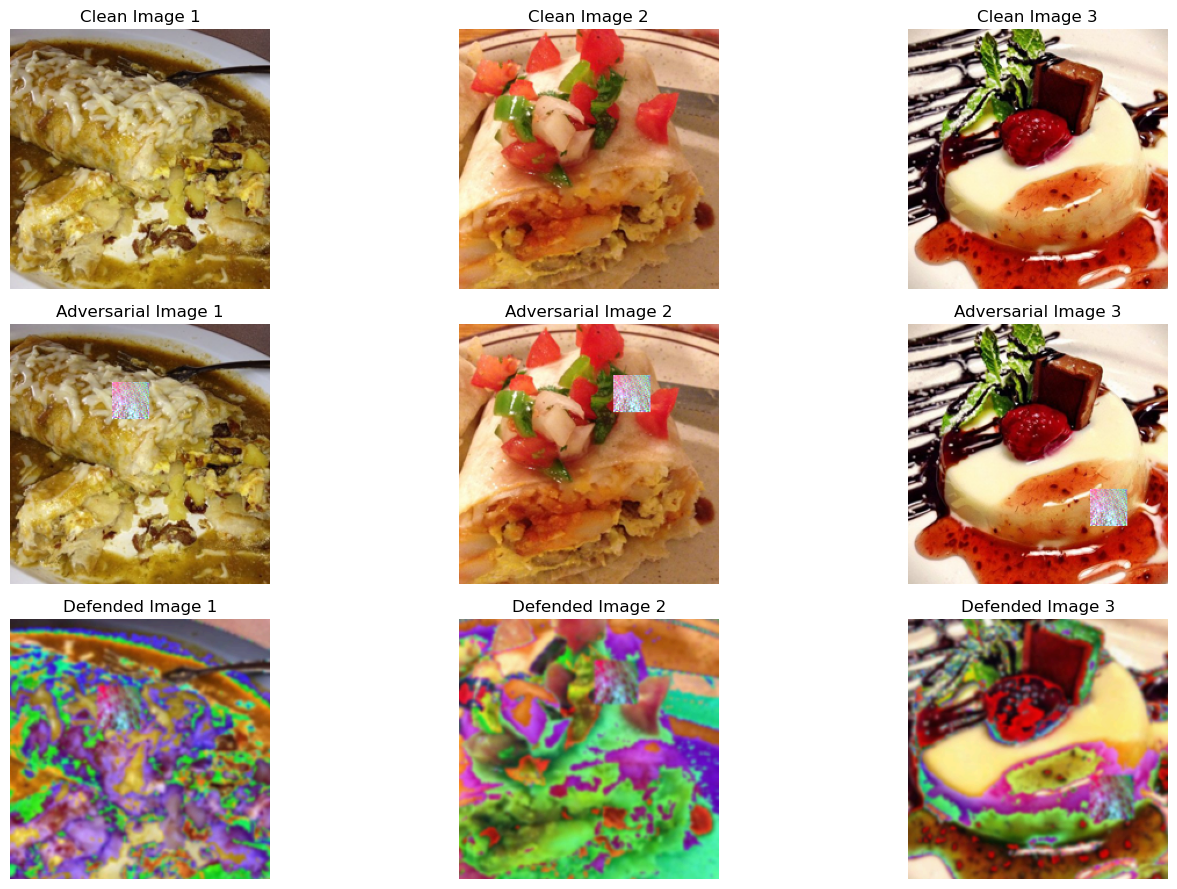

Defense visualization saved as 'defense_examples.png'

=== Defense Evaluation Complete ===


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_NAME = 'vit_base_patch16_224'
PATCH_SIZE = 32
BATCH_SIZE = 16
TARGET_LABEL = 957  # spaghetti class

print(f"Using device: {DEVICE}")

class PreprocessingDefense:
    """Collection of preprocessing defenses against adversarial patches"""
    
    def __init__(self):
        pass
    
    def gaussian_blur(self, image, sigma=1.0):
        """Apply Gaussian blur to reduce patch effectiveness"""
        if isinstance(image, torch.Tensor):
            # Convert to numpy for OpenCV processing
            img_np = image.cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np * 255).astype(np.uint8)
            
            # Apply Gaussian blur
            blurred = cv2.GaussianBlur(img_np, (5, 5), sigma)
            
            # Convert back to tensor
            blurred_tensor = torch.from_numpy(blurred.transpose(2, 0, 1) / 255.0).float()
            return blurred_tensor.to(image.device)
        return image
    
    def random_crop_resize(self, image, crop_ratio=0.85):
        """Randomly crop and resize to disrupt patch placement"""
        if isinstance(image, torch.Tensor):
            _, h, w = image.shape
            new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
            
            # Random crop
            top = random.randint(0, h - new_h)
            left = random.randint(0, w - new_w)
            
            cropped = image[:, top:top+new_h, left:left+new_w]
            
            # Resize back to original size
            resized = F.interpolate(cropped.unsqueeze(0), size=(h, w), mode='bilinear', align_corners=False)
            return resized.squeeze(0)
        return image
    
    def bit_depth_reduction(self, image, bits=6):
        """Reduce bit depth to remove fine-grained adversarial perturbations"""
        if isinstance(image, torch.Tensor):
            # Quantize to fewer bits
            levels = 2 ** bits
            quantized = torch.round(image * (levels - 1)) / (levels - 1)
            return torch.clamp(quantized, 0, 1)
        return image
    
    def apply_defense(self, image, methods=['gaussian_blur', 'random_crop_resize']):
        """Apply multiple preprocessing defenses"""
        defended_image = image.clone() if isinstance(image, torch.Tensor) else image.copy()
        
        for method in methods:
            if method == 'gaussian_blur':
                defended_image = self.gaussian_blur(defended_image)
            elif method == 'random_crop_resize':
                defended_image = self.random_crop_resize(defended_image)
            elif method == 'bit_depth_reduction':
                defended_image = self.bit_depth_reduction(defended_image)
        
        return defended_image

class EnsembleDefense:
    """Ensemble of multiple models for robust classification"""
    
    def __init__(self, model_names=['vit_base_patch16_224', 'resnet50']):
        self.models = []
        self.device = DEVICE
        
        # Load different model architectures
        for model_name in model_names:
            try:
                model = timm.create_model(model_name, pretrained=True, num_classes=1000)
                model = model.to(self.device)
                model.eval()
                self.models.append(model)
                print(f"Loaded {model_name}")
            except Exception as e:
                print(f"Failed to load {model_name}: {e}")
    
    def predict(self, images, voting='soft'):
        """Make ensemble predictions"""
        all_predictions = []
        
        with torch.no_grad():
            for model in self.models:
                outputs = model(images)
                if voting == 'soft':
                    predictions = F.softmax(outputs, dim=1)
                else:
                    predictions = F.one_hot(outputs.argmax(dim=1), num_classes=1000).float()
                all_predictions.append(predictions)
        
        # Average predictions
        ensemble_pred = torch.stack(all_predictions).mean(dim=0)
        return ensemble_pred
    
    def evaluate_robustness(self, clean_images, adversarial_images, true_labels):
        """Evaluate ensemble robustness against adversarial patches"""
        clean_pred = self.predict(clean_images)
        adv_pred = self.predict(adversarial_images)
        
        clean_acc = (clean_pred.argmax(dim=1) == true_labels).float().mean()
        adv_acc = (adv_pred.argmax(dim=1) == true_labels).float().mean()
        
        return {
            'clean_accuracy': clean_acc.item(),
            'adversarial_accuracy': adv_acc.item(),
            'robustness_drop': (clean_acc - adv_acc).item()
        }

class IntegratedDefenseSystem:
    """Comprehensive defense system combining multiple strategies"""
    
    def __init__(self):
        self.device = DEVICE
        self.preprocessing_defense = PreprocessingDefense()
        self.ensemble_defense = None
        
        print("Integrated defense system initialized")
    
    def setup_defenses(self):
        """Setup and calibrate all defense components"""
        print("Setting up defense components...")
        
        # Setup ensemble defense
        print("Initializing ensemble defense...")
        self.ensemble_defense = EnsembleDefense()
        
        print("Defense system ready!")
    
    def defend_image(self, image, use_preprocessing=True):
        """Apply defense to a single image"""
        defended_image = image.clone()
        
        # Apply preprocessing defense
        if use_preprocessing:
            defended_image = self.preprocessing_defense.apply_defense(
                defended_image,
                methods=['gaussian_blur', 'random_crop_resize', 'bit_depth_reduction']
            )
        
        return defended_image
    
    def evaluate_defense(self, clean_images, adversarial_images, true_labels, model):
        """Evaluate the complete defense system"""
        results = {
            'clean_accuracy': 0,
            'adversarial_accuracy_no_defense': 0,
            'adversarial_accuracy_with_defense': 0,
            'ensemble_clean_accuracy': 0,
            'ensemble_adversarial_accuracy': 0
        }
        
        model.eval()
        
        with torch.no_grad():
            # Evaluate on clean images
            clean_pred = model(clean_images)
            clean_acc = (clean_pred.argmax(dim=1) == true_labels).float().mean()
            results['clean_accuracy'] = clean_acc.item()
            
            # Evaluate on adversarial images without defense
            adv_pred_no_defense = model(adversarial_images)
            adv_acc_no_defense = (adv_pred_no_defense.argmax(dim=1) == true_labels).float().mean()
            results['adversarial_accuracy_no_defense'] = adv_acc_no_defense.item()
            
            # Evaluate with preprocessing defense
            defended_images = []
            for img in adversarial_images:
                defended_img = self.defend_image(img)
                defended_images.append(defended_img)
            
            defended_images = torch.stack(defended_images)
            adv_pred_with_defense = model(defended_images)
            adv_acc_with_defense = (adv_pred_with_defense.argmax(dim=1) == true_labels).float().mean()
            results['adversarial_accuracy_with_defense'] = adv_acc_with_defense.item()
            
            # Evaluate ensemble defense if available
            if self.ensemble_defense:
                ensemble_results = self.ensemble_defense.evaluate_robustness(
                    defended_images, adversarial_images, true_labels
                )
                results['ensemble_clean_accuracy'] = ensemble_results['clean_accuracy']
                results['ensemble_adversarial_accuracy'] = ensemble_results['adversarial_accuracy']
        
        return results

def create_adversarial_test_data(dataloader, patch, num_samples=50):
    """Create adversarial test data by applying patches"""
    clean_images = []
    adversarial_images = []
    labels = []
    
    count = 0
    for images, batch_labels in dataloader:
        if count >= num_samples:
            break
            
        images = images.to(DEVICE)
        batch_labels = batch_labels.to(DEVICE)
        
        # Create adversarial versions
        for i, (img, label) in enumerate(zip(images, batch_labels)):
            if count >= num_samples:
                break
                
            # Random patch placement
            img_height, img_width = 224, 224  # Standard ViT input size
            start_x = random.randint(0, img_width - PATCH_SIZE)
            start_y = random.randint(0, img_height - PATCH_SIZE)
            
            # Apply patch
            adv_img = img.clone()
            adv_img[:, start_y:start_y+PATCH_SIZE, start_x:start_x+PATCH_SIZE] = patch
            
            clean_images.append(img)
            adversarial_images.append(adv_img)
            labels.append(label)
            count += 1
    
    return torch.stack(clean_images), torch.stack(adversarial_images), torch.stack(labels)

def visualize_defense_examples(clean_imgs, adv_imgs, defended_imgs, num_examples=3):
    """Visualize clean, adversarial, and defended images"""
    fig, axes = plt.subplots(3, num_examples, figsize=(15, 9))
    
    for i in range(num_examples):
        # Clean image
        clean_img = clean_imgs[i].cpu().permute(1, 2, 0)
        clean_img = (clean_img - clean_img.min()) / (clean_img.max() - clean_img.min())
        axes[0, i].imshow(clean_img)
        axes[0, i].set_title(f'Clean Image {i+1}')
        axes[0, i].axis('off')
        
        # Adversarial image
        adv_img = adv_imgs[i].cpu().permute(1, 2, 0)
        adv_img = (adv_img - adv_img.min()) / (adv_img.max() - adv_img.min())
        axes[1, i].imshow(adv_img)
        axes[1, i].set_title(f'Adversarial Image {i+1}')
        axes[1, i].axis('off')
        
        # Defended image
        defended_img = defended_imgs[i].cpu().permute(1, 2, 0)
        defended_img = (defended_img - defended_img.min()) / (defended_img.max() - defended_img.min())
        axes[2, i].imshow(defended_img)
        axes[2, i].set_title(f'Defended Image {i+1}')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('defense_examples.png', dpi=150, bbox_inches='tight')
    plt.show()

def main():
    """Main function to run the defense evaluation"""
    print("=== Adversarial Patch Defense System ===")
    
    # Load the original model and data
    model = timm.create_model(MODEL_NAME, pretrained=True).to(DEVICE)
    model.eval()
    
    data_config = timm.data.resolve_model_data_config(model)
    transform = timm.data.create_transform(**data_config, is_training=False)
    
    # Load test dataset
    test_dataset = torchvision.datasets.Food101(root="./data", split='test', download=True, transform=transform)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    print(f"Loaded test dataset with {len(test_dataset)} images")
    
    # Load your trained adversarial patch
    try:
        adversarial_patch = torch.load("7's.pt", map_location=DEVICE)
        print("Loaded adversarial patch successfully")
    except FileNotFoundError:
        print("Adversarial patch not found. Creating a dummy patch for testing.")
        adversarial_patch = torch.rand(3, PATCH_SIZE, PATCH_SIZE, device=DEVICE)
    
    # Initialize defense system
    defense_system = IntegratedDefenseSystem()
    defense_system.setup_defenses()
    
    # Create test data
    print("Creating test data...")
    clean_test_images, adversarial_test_images, test_labels = create_adversarial_test_data(
        test_dataloader, adversarial_patch, num_samples=50
    )
    
    print(f"Created {len(clean_test_images)} test samples")
    
    # Evaluate the defense system
    print("Evaluating defense system...")
    results = defense_system.evaluate_defense(
        clean_test_images, adversarial_test_images, test_labels, model
    )
    
    print("\n=== Defense Evaluation Results ===")
    print(f"Clean Accuracy: {results['clean_accuracy']:.3f}")
    print(f"Adversarial Accuracy (No Defense): {results['adversarial_accuracy_no_defense']:.3f}")
    print(f"Adversarial Accuracy (With Defense): {results['adversarial_accuracy_with_defense']:.3f}")
    
    if results['ensemble_clean_accuracy'] > 0:
        print(f"Ensemble Clean Accuracy: {results['ensemble_clean_accuracy']:.3f}")
        print(f"Ensemble Adversarial Accuracy: {results['ensemble_adversarial_accuracy']:.3f}")
    
    # Calculate improvement
    improvement = results['adversarial_accuracy_with_defense'] - results['adversarial_accuracy_no_defense']
    print(f"\nDefense Improvement: {improvement:.3f} ({improvement*100:.1f}% points)")
    
    if improvement > 0:
        print("✅ Defense system successfully improved robustness!")
    else:
        print("❌ Defense system needs tuning.")
        
    # Calculate attack success rate
    attack_success_no_defense = 1 - results['adversarial_accuracy_no_defense']
    attack_success_with_defense = 1 - results['adversarial_accuracy_with_defense']
    defense_effectiveness = (attack_success_no_defense - attack_success_with_defense) / attack_success_no_defense if attack_success_no_defense > 0 else 0
    
    print(f"\nAttack Success Rate (No Defense): {attack_success_no_defense:.3f}")
    print(f"Attack Success Rate (With Defense): {attack_success_with_defense:.3f}")
    print(f"Defense Effectiveness: {defense_effectiveness:.3f} ({defense_effectiveness*100:.1f}% reduction in attack success)")
    
    # Create defended versions for visualization
    defended_examples = []
    for i in range(3):
        defended_img = defense_system.defend_image(adversarial_test_images[i])
        defended_examples.append(defended_img)
    
    defended_examples = torch.stack(defended_examples)
    
    # Visualize
    print("\nCreating visualization...")
    visualize_defense_examples(
        clean_test_images[:3], 
        adversarial_test_images[:3], 
        defended_examples
    )
    
    print("Defense visualization saved as 'defense_examples.png'")
    print("\n=== Defense Evaluation Complete ===")

if __name__ == "__main__":
    main()